In [54]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor

pd.set_option('display.max_colwidth', 355)
pd.set_option('display.max_rows', 100)

ModuleNotFoundError: No module named 'sklearn'

In [3]:
df = pd.read_csv('datasets/b3_stocks_1994_2020.csv')

### IBOV Ações - Exploração inicial

In [4]:
df.head()

,datetime,ticker,open,close,high,low,volume
0,1994-07-04,ACE 3,48.00,48.00,48.00,47.00,46550.0
1,1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
2,1994-07-04,ALP 4,131.00,131.00,131.00,131.00,6550.0
3,1994-07-04,IBP 6,600.00,600.00,600.00,600.00,7800.0
4,1994-07-04,AQT 4,0.89,0.99,0.99,0.85,13137.0


In [5]:
df.shape

(1883203, 7)

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [31]:
df['delta_open'] = df.apply(lambda x: (abs(x['open'] - x['close']) / x['open']) * 100, axis=1)

<AxesSubplot:xlabel='delta_open'>

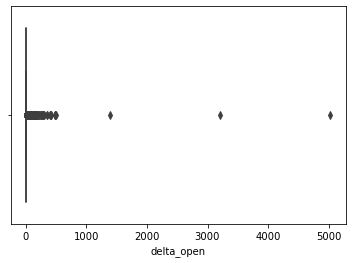

In [32]:
sns.boxplot(x=df['delta_open'])

In [33]:
df['delta_high'] = df.apply(lambda x: (abs(x['high'] - x['close']), axis=1)

SyntaxError: invalid syntax (1152329184.py, line 1)

In [34]:
df.head()

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high
306827,2000-01-04,BBDC3,10.70,10.11,10.70,10.11,712264.00,5.514019,0.59
306828,2000-01-04,BBDC4,13.97,13.00,13.97,13.00,18227635.00,6.943450,0.97
306829,2000-01-03,CSNA3,70.00,73.00,73.00,69.00,1428849.00,4.285714,4.00
306830,2000-01-03,CRTP5,315.00,307.50,315.00,303.00,477392.83,2.380952,12.00
306831,2000-01-03,ELET6,42.58,41.99,44.70,41.00,27195246.00,1.385627,3.70


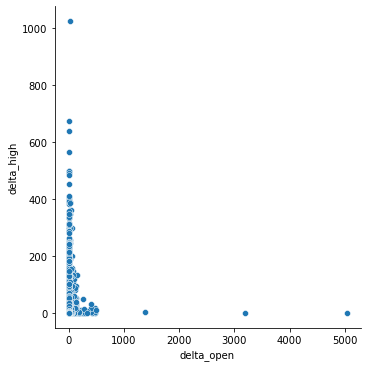

In [35]:
sns.relplot(x="delta_open", y="delta_high", data=df);

In [36]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,open,close,high,low,volume,delta_open,delta_high
count,1576375.00000,1576375.00000,1576375.00000,1576375.00000,1576375.00000,1576375.00000,1576375.00000
mean,58.93044,58.96896,59.42093,58.44035,19556444.80539,1.93853,0.98058
std,1608.08544,1608.09699,1608.21984,1607.95151,111682195.00896,6.33195,4.60893
min,0.01000,0.00000,0.01000,0.01000,0.00000,0.00000,0.00000
25%,4.51000,4.51000,4.61000,4.44000,26000.00000,0.08326,0.03000
50%,13.99000,13.99000,14.18000,13.72000,410986.00000,1.01010,0.28000
75%,34.50000,34.50000,35.00000,34.00000,7327806.50000,2.43902,0.78000
max,1297776.47000,1297776.47000,1297776.47000,1297776.47000,42983799660.00000,5028.20513,1025.00000


In [37]:
# ZOOM NOS NORMAIS
# sns.relplot(x="delta_open", y="delta_high", data=df.loc[df['delta_high'] < 1000])

In [38]:
df.loc[df['delta_high'] > 1000].head(100)

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high
531781,2004-05-20,AESL3,3999.99,2974.99,3999.99,2974.99,10974.97,25.625064,1025.0


## Usaremos dados depois de 95 por causa do plano real
Deltas extramamente altas levantaram a suspeita

In [39]:
df = df.loc[df['datetime'] > '1995-01-01']

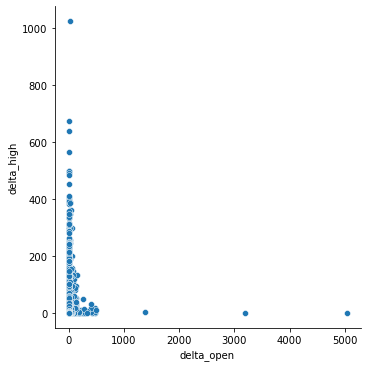

In [40]:
sns.relplot(x="delta_open", y="delta_high", data=df);

In [41]:
df.loc[df['delta_high'] > 6000].head(1)

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high


### vamos recortar essa observação que esta extremamente descolada

In [42]:
df = df.loc[df['delta_high'] < 6999]

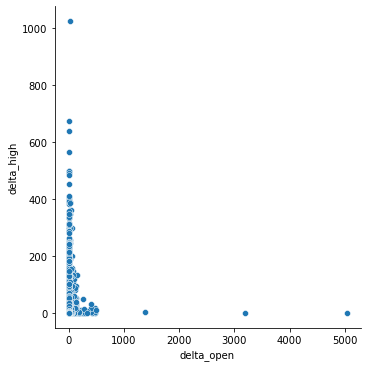

In [43]:
sns.relplot(x="delta_open", y="delta_high", data=df)

<AxesSubplot:xlabel='delta_high'>

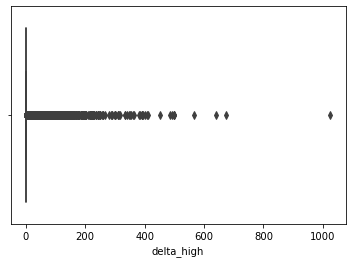

In [44]:
sns.boxplot(x=df['delta_high'])

In [45]:
df.loc[df['delta_high'] > 600].head(10)

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high
531781,2004-05-20,AESL3,3999.99,2974.99,3999.99,2974.99,10974.97,25.625064,1025.00
565274,2004-11-16,AESL3,8501.12,9175.00,9175.00,8501.12,300236.30,7.926956,673.88
1833124,2020-09-04,AMZO34,8796.00,8770.11,8900.00,8260.00,53710279.90,0.294338,640.00


## Vamos usar apenas dados desse seculo
nao conseguimos achar esssas acoes antigas

In [46]:
df = df.loc[df['datetime'] > '2000-01-01']

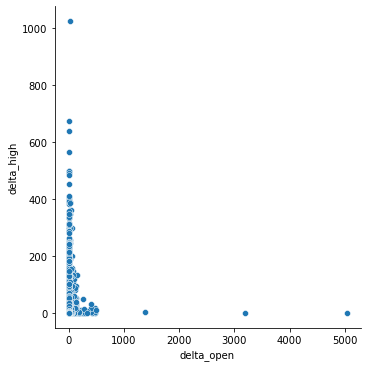

In [47]:
sns.relplot(x="delta_open", y="delta_high", data=df)

In [48]:
df.loc[df['delta_high'] > 600].head(10)

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high
531781,2004-05-20,AESL3,3999.99,2974.99,3999.99,2974.99,10974.97,25.625064,1025.00
565274,2004-11-16,AESL3,8501.12,9175.00,9175.00,8501.12,300236.30,7.926956,673.88
1833124,2020-09-04,AMZO34,8796.00,8770.11,8900.00,8260.00,53710279.90,0.294338,640.00


<AxesSubplot:xlabel='datetime', ylabel='close'>

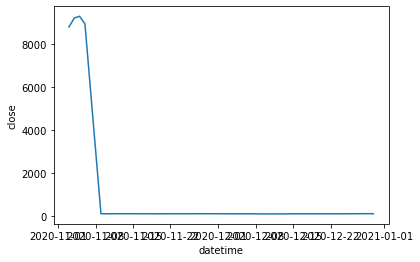

In [49]:
sns.lineplot(x='datetime', y='close', data=df.loc[(df['ticker'] == 'AMZO34') & (df['datetime'] > '2020-11-01') & (df['datetime'] > '2020-11-01')])

In [50]:
df.loc[(df['ticker'] == 'AMZO34') & (df['datetime'] > '2020-11-01') & (df['datetime'] > '2020-11-01')]

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high
1854244,2020-11-03,AMZO34,8638.99,8779.45,8840.00,8444.44,14952140.22,1.625885,395.56
1854245,2020-11-04,AMZO34,8951.00,9194.65,9194.65,8951.00,9608634.26,2.722042,243.65
1854246,2020-11-05,AMZO34,9207.00,9280.00,9350.00,9164.90,7387944.57,0.792875,185.10
1854247,2020-11-06,AMZO34,9280.00,8926.50,9280.00,8870.00,12508258.30,3.809267,410.00
1854248,2020-11-09,AMZO34,113.71,108.81,117.95,105.96,29284445.04,4.309208,11.99
1854249,2020-11-10,AMZO34,106.08,105.47,107.27,103.30,30493277.04,0.575038,3.97
1859273,2020-11-11,AMZO34,106.29,107.55,108.05,104.85,20231314.93,1.185436,3.20
1859274,2020-11-12,AMZO34,107.92,108.60,109.61,107.15,12690454.53,0.630096,2.46
1859275,2020-11-13,AMZO34,108.66,108.88,110.11,107.78,11766562.93,0.202466,2.33
1859276,2020-11-16,AMZO34,107.32,108.88,109.06,106.02,9451368.82,1.453597,3.04


### Seriam esses dois dados ruido?

In [51]:
df.loc[df['delta_open'] > 10].head(10)

,datetime,ticker,open,close,high,low,volume,delta_open,delta_high
306866,2000-01-04,TRPL4,6.24,5.45,6.24,5.45,2023269.00,12.660256,0.79
306882,2000-01-05,TRPL4,5.51,6.19,6.19,5.20,1121662.00,12.341198,0.99
306883,2000-01-05,TRPL3,4.16,4.60,4.60,4.00,161235.00,10.576923,0.60
306998,2000-01-14,BBDC3,11.40,12.60,12.60,11.40,4971887.00,10.526316,1.20
307007,2000-01-12,SCAR3,4.85,4.00,4.85,4.00,885.00,17.525773,0.85
307034,2000-01-13,TCSL4,6.20,6.85,6.85,6.15,45155325.00,10.483871,0.70
307069,2000-01-17,CRTP5,411.00,470.00,474.00,411.00,3644079.65,14.355231,63.00
307165,2000-01-20,CHAP4,0.14,0.12,0.14,0.12,313127.00,14.285714,0.02
307236,2000-01-21,REAL3,1.20,1.00,1.20,1.00,19600.00,16.666667,0.20
307246,2000-01-21,TNEP3,3.11,3.49,3.50,3.10,451448.00,12.218650,0.40


### resolvemos tirar o delta_high pois nao traz informação util

In [56]:
df = df.drop(['delta_high', 'volume'], axis=1)

### LOF

In [53]:
def get_LOF_scores(df, n_neighbors=10, contamination=0.05):
    np.random.seed(42)

    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(df)

    X_scores = clf.negative_outlier_factor_
    
    df['LOF_score'] = X_scores
    df['LOF_predictions'] = y_pred
    
    return df